In [ ]:
import sys
import subprocess
import pkg_resources

required = {'numpy', 'pandas', 'pathlib', 'nltk', 'gensim', 'wordcloud'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [ ]:
import numpy as np
import pandas as pd
import json
import os

# Import data

In [ ]:
BASE_PATH = 'clinguistics_labs'

if not os.path.exists(BASE_PATH):
  !git clone https://github.com/pazamelin/clinguistics_labs.git

DATASET_PATH = f'{BASE_PATH}/news_parser/artifacts/merged.json'

Cloning into 'clinguistics_labs'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (376/376), done.
remote: Compressing objects: 100% (366/366), done.
remote: Total 376 (delta 21), reused 354 (delta 8), pack-reused 0
Receiving objects: 100% (376/376), 66.89 MiB | 10.95 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Checking out files: 100% (334/334), done.


In [ ]:
dataset = None
with open(DATASET_PATH) as json_file:
    dataset_raw = json.load(json_file)
    columns = dataset_raw['catalog'][0].keys()
    dataset = pd.DataFrame(columns=columns, data=dataset_raw['catalog'])
    
# transormations
for index, row in dataset.iterrows():
    if row['category'] == '#comp-comments':
        row['article_id'] = row['article_id'][:-len('/#comp-comments-button')]
        url = row['article_id']
        row['category'] = url[url.rfind('/')+1:url.rfind('-')]
        
dataset

,article_id,category,title,tags,text
0,http://www.bbc.co.uk/news/world-europe-55497084,world-europe,Brexit: Gibraltar gets UK-Spain deal to keep o...,"Gibraltar,Spain,Effects of Brexit on Gibraltar...",Spain has reached a deal with the UK to mainta...
1,http://www.bbc.co.uk/news/uk-northern-ireland-...,uk-northern-ireland,Covid-19: Homeschooling returns for first week...,"NI education,Coronavirus lockdown measures,Cor...",Most pupils in Northern Ireland will not be re...
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",Nearly half a century of the UK's membership o...
3,http://www.bbc.co.uk/news/uk-england-merseysid...,uk-england-merseyside,Joe Anderson: Liverpool mayor in police probe ...,"Liverpool City Council,Liverpool",Liverpool Mayor Joe Anderson says he will not ...
4,http://www.bbc.co.uk/news/uk-55502595,uk,"Covid-19: UK reports a record 55,892 daily cases","Healthcare,Coronavirus pandemic","The UK has reported another 55,892 daily cases..."
...,...,...,...,...,...
23602,http://www.bbc.co.uk/news/world-australia-5947...,world-australia,Australian parliament: One in three workers se...,"Sexual harassment,Australia",A third of employees in Australia's federal pa...
23603,http://www.bbc.co.uk/news/explainers-52544307,explainers,What Covid tests do I still need to travel abr...,"Tourism,Spain,France,Coronavirus lockdown meas...","From next month, fully vaccinated people trave..."
23604,http://www.bbc.co.uk/news/world-middle-east-59...,world-middle-east,Yemen: The children haunted by 'ghosts' of war,NaN,
23605,http://www.bbc.co.uk/news/business-59466803,business,Facial recognition firm faces possible £17m pr...,"Facial recognition,Information Commissioner's ...",An Australian firm which claims to have a data...


In [ ]:
dataset['category'].value_counts()[:20]

uk                               3507
business                         2323
uk-wales                         1936
health                           1457
world-us-canada                  1414
uk-politics                      1389
uk-northern-ireland              1231
world-europe                     1015
uk-scotland                       863
entertainment-arts                833
world-asia                        672
science-environment               565
uk-england-london                 559
explainers                        435
technology                        409
education                         337
uk-wales-politics                 331
world-middle-east                 315
uk-scotland-scotland-politics     266
world                             247
Name: category, dtype: int64

In [ ]:
categories_to_keep = ['business', 'health', 'uk-politics', 'entertainment-arts']
max_category_size = 1000

dataset = dataset[dataset['category'].isin(categories_to_keep)]
category_datasets = []
for category in categories_to_keep:
    category_datasets.append(dataset[dataset['category'] == category][:max_category_size])
    
result = category_datasets[0]
for ds in category_datasets[1:]:
    result = result.append(ds)
    
dataset = result
dataset

,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",Nearly half a century of the UK's membership o...
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets",Last year was the worst for the High Street in...
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...",The 5% rate of VAT on sanitary products - refe...
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency","Bitcoin's value surged above $34,000 (£24,850)..."
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...",Working parents trying to balance work and chi...
...,...,...,...,...,...
23480,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Radio 4's Today programme temporarily drops of...,Radio,Radio 4's Today programme temporarily dropped ...
23503,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Storm Arwen: I'm a Celebrity to return on Tues...,"ITV,Television,I'm a Celebrity...Get Me Out of...",Live episodes of I'm a Celebrity... Get Me Out...
23507,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Steps axe their remaining tour dates due to fu...,Live music,Pop group Steps have announced they have are p...
23536,http://www.bbc.co.uk/news/entertainment-arts-5...,entertainment-arts,Adele announces Las Vegas residency,"Las Vegas,Music,Adele",Adele has announced a Las Vegas residency with...


In [ ]:
print(dataset.isna().sum())
dataset = dataset.dropna()

article_id      0
category        0
title           0
tags          193
text            0
dtype: int64


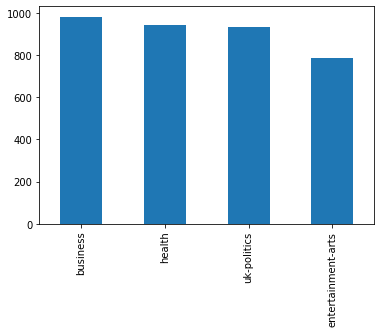

In [ ]:
s = dataset['category'].value_counts()
s.plot(kind='bar')

# Text Pre-Processing - Stop-word removal, Stemming, Vectorization

In [ ]:
import re 
from os import listdir
from os.path import isfile, join
import json
import pathlib
import re 
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import sklearn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')
VECTORIZER = None
bigram_mod = None
trigram_mod = None

def clean(text):
    cleaned = re.sub(re.compile('<.*?>'), '', text)
    cleaned = re.sub('[^A-Za-z0-9]+', ' ', cleaned)
    cleaned = cleaned.lower()
    return cleaned
    
    
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens


def remove_stop_words(tokens):
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return filtered_tokens


def make_bigrams(tokens):
    return bigram_mod[tokens]


def make_trigrams(tokens):
    return trigram_mod[bigram_mod[tokens]]


def apply_stemming(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens
    
def vectorize(tokens, vectorizer):
    vectorized_tokens = vectorizer.fit(tokens)
    return vectorized_tokens


def preprocess_text_init(text):
    cleaned_text = clean(text)
    tokens = tokenize(cleaned_text)
    return tokens
    
def preprocess_text(text):  
    tokens = tokenize(text)
    tokens = remove_stop_words(tokens)
    tokens = apply_stemming(tokens)
    tokens = make_bigrams(tokens) 
    return tokens



In [ ]:
# dataset = dataset[:100]

# preprocess corpus
for index, row in dataset.iterrows():
    row['text'] = preprocess_text_init(row['text'])
    row['text'] = ' '.join(row['text'])

dataset.head(5)

,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...",nearly half a century of the uk s membership o...
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets",last year was the worst for the high street in...
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...",the 5 rate of vat on sanitary products referre...
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency",bitcoin s value surged above 34 000 24 850 for...
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...",working parents trying to balance work and chi...


In [ ]:
import gensim
from gensim.utils import simple_preprocess

data_words = dataset.values.tolist()

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

for index, row in dataset.iterrows():
    row['text'] = preprocess_text(row['text'])

dataset.head(5)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


,article_id,category,title,tags,text
2,http://www.bbc.co.uk/news/business-55494101,business,Adieu to the single market created by the UK,"Companies,EU-UK post-Brexit trade talks,Boris ...","[nearli, half, centuri, uk, membership, europe..."
9,http://www.bbc.co.uk/news/business-55501049,business,'Worst year for High Street job losses in 25 y...,"Retailing,UK economy,UK High Streets","[last, year, worst, high, street, 25, year, co..."
35,http://www.bbc.co.uk/news/business-55502252,business,Activists cheer as 'sexist' tampon tax is scra...,"Companies,Budget 2020,Women's health,Money,Per...","[5, rate, vat, sanitari, product, refer, tampo..."
76,http://www.bbc.co.uk/news/business-55515529,business,"Bitcoin tops $34,000 as record rally continues","Bitcoin,Cryptocurrency","[bitcoin, valu, surg, 34, 000, 24, 850, first,..."
173,http://www.bbc.co.uk/news/business-55522104,business,'Furlough mums and dads while schools are off'...,"Trades Union Congress,Job Retention Scheme,Cor...","[work, parent, tri, balanc, work, childcar, pu..."


In [ ]:
dataset.text

2        [nearli, half, centuri, uk, membership, europe...
9        [last, year, worst, high, street, 25, year, co...
35       [5, rate, vat, sanitari, product, refer, tampo...
76       [bitcoin, valu, surg, 34, 000, 24, 850, first,...
173      [work, parent, tri, balanc, work, childcar, pu...
                               ...                        
23480    [radio, 4, today, programm, temporarili, drop,...
23503    [live, episod, celebr, get, return, tuesday, i...
23507    [pop, group, step, announc, postpon, remaind, ...
23536    [adel, announc, la, vega, resid, weekend, perf...
23566    [bree, runway, lola, young, holli, humberston,...
Name: text, Length: 3640, dtype: object

['nearli', 'half', 'centuri', 'uk', 'membership', 'european', 'union', 'predecessor', 'organis', 'end', 'januari', 'cours', 'end', 'uk', 'econom', 'membership', 'bloc', 'forti', 'eight', 'year', 'european', 'custom', 'union', 'basic', 'common', 'market', '28', 'year', 'singl', 'market', 'singl', 'market', 'creation', 'uk', 'patern', 'right', 'margaret', 'thatcher', 'ralli', 'call', 'european', 'reform', 'call', 'card', 'unleash', 'wave', 'japanes', 'invest', 'post', 'industri', 'britain', 'shepherd', 'exist', 'appointe', 'commission', 'arthur', 'cockfield', 'creation', 'serv', 'uk', 'econom', 'interest', 'grew', 'home', 'domest', 'market', 'avail', 'british', 'export', 'without', 'tariff', 'non', 'tariff', 'barrier', 'eventu', 'nearli', 'half', 'billion', 'european', 'without', 'ironi', 'tortuou', 'negoti', 'past', 'four', 'year', 'made', 'tougher', 'eu', 'insist', 'defend', 'call', 'intern', 'market', 'creat', 'british', 'inde', 'institut', 'underpin', 'huge', 'marketplac', 'becam', '

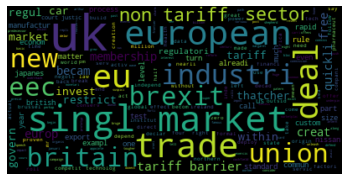

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
% matplotlib inline

text_sample = dataset['text'].iloc[0]
print(str(text_sample))
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(' '.join(text_sample))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import gensim.corpora as corpora

data_stemmatized = dataset.text.values.tolist()
# Create Dictionary
id2word = corpora.Dictionary(data_stemmatized)

# Create Corpus
texts = data_stemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
print(corpus[0][:64])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 2), (10, 2), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 6), (46, 1), (47, 5), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 6), (62, 6), (63, 3)]


Base LDA Model

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)


from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"year" + 0.012*"number" + 0.011*"last" + 0.010*"week" + '
  '0.010*"record" + 0.010*"one" + 0.009*"band" + 0.009*"uk" + 0.007*"show" + '
  '0.007*"hit"'),
 (1,
  '0.026*"said" + 0.013*"uk" + 0.013*"govern" + 0.011*"would" + 0.010*"minist" '
  '+ 0.009*"johnson" + 0.009*"go" + 0.008*"tour" + 0.007*"test" + '
  '0.007*"festiv"'),
 (2,
  '0.029*"uk" + 0.019*"said" + 0.016*"eu" + 0.011*"brexit" + 0.010*"deal" + '
  '0.009*"ireland" + 0.009*"compani" + 0.009*"trade" + 0.008*"northern" + '
  '0.008*"would"'),
 (3,
  '0.025*"nomin" + 0.015*"uk" + 0.012*"oscar" + 0.011*"new" + 0.010*"world" + '
  '0.010*"pop" + 0.010*"year" + 0.009*"sondheim" + 0.009*"chang" + '
  '0.008*"winner"'),
 (4,
  '0.046*"vaccin" + 0.022*"peopl" + 0.021*"covid" + 0.014*"uk" + 0.012*"dose" '
  '+ 0.010*"infect" + 0.010*"test" + 0.009*"age" + 0.009*"variant" + '
  '0.009*"viru"'),
 (5,
  '0.026*"cum" + 0.014*"wear" + 0.014*"face" + 0.013*"writer" + 0.013*"public" '
  '+ 0.011*"mask" + 0.009*"cover" + 0.009

In [ ]:
! pip install pyLDAvis
import pyLDAvis.gensim_models
import gensim
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Как видим из диаграммы, выделенные темы имеют много пересечений, также они сгруппированны примерно в одной области. Можем сделать вывод, что модель недостаточно хорошо идентифицировала темы и требует дальнейшего подбора гиперпараметров.


In [ ]:
display(data)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.042443 -0.017740       1        1  23.536884
4      0.097580 -0.154356       2        1  16.633046
6     -0.159731 -0.002937       3        1  12.047007
1     -0.035973 -0.065698       4        1  10.877838
8     -0.178599  0.124706       5        1   9.297210
0      0.009806 -0.149781       6        1   8.963109
2     -0.017616  0.129326       7        1   7.683200
7     -0.059255 -0.147086       8        1   5.030467
3      0.053216  0.234637       9        1   3.557501
5      0.333016  0.048929      10        1   2.373738, topic_info=         Term          Freq         Total Category  logprob  loglift
473    vaccin  10708.000000  10708.000000  Default  30.0000  30.0000
460        uk  10768.000000  10768.000000  Default  29.0000  29.0000
283        mr   5514.000000   5514.000000  Default  28.0000  28.0000
116     covid   6444.000000   6444.000000  Default  27.0000  27.0000
490      year   8034.000000   8034.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
22       also    249.508894   6700.344351  Topic10  -4.8741   0.4503
833    requir    166.262261    895.521081  Topic10  -5.2800   2.0569
634     peopl    229.275031  10744.678221  Topic10  -4.9587  -0.1065
1291      ask    151.199899   1837.746172  Topic10  -5.3750   1.2430
765   england    148.313172   3265.414174  Topic10  -5.3943   0.6489

[678 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2903      6  0.993812     0
493       1  0.494154   000
493       2  0.093848   000
493       4  0.096755   000
493       5  0.006644   000
...     ...       ...   ...
490       5  0.033605  year
490       6  0.273940  year
490       7  0.027257  year
490       8  0.003858  year
490       9  0.057999  year

[1590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 5, 7, 2, 9, 1, 3, 8, 4, 6])

Когерентность

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_stemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.41458030316177874


Hyperparameter Tuning

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_stemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
# https://github.com/kuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [ ]:
import numpy as np
import pandas as pd
import tqdm

# parameters ranges
topics_range = range(2, 5)
alpha_range = [x * 0.2 for x in range(1, 6)]
beta_range = [x * 0.2 for x in range(1, 6)]

# validation set
num_of_docs = len(corpus)
# validation_set = gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75)
validation_set = corpus[:100]

# tuning
combinations = []
for k in topics_range:
    for a in alpha_range:
        for b in beta_range:
            combinations.append([k, a, b])

            
tuningResults = pd.DataFrame(data=[], columns=['index', 'topics', 'alpha', 'beta', 'coherence'])

i = 0
for combination in log_progress(combinations, every=1):
    k, a, b = combination
    cv = compute_coherence_values(corpus=validation_set, dictionary=id2word, k=k, a=a, b=b)
    tuningResults.loc[i] = [i, k, a, b, cv]
    i += 1


tuningResults

,index,topics,alpha,beta,coherence
0,0.0,2.0,0.2,0.2,0.348492
1,1.0,2.0,0.2,0.4,0.340956
2,2.0,2.0,0.2,0.6,0.362414
3,3.0,2.0,0.2,0.8,0.360081
4,4.0,2.0,0.2,1.0,0.359956
...,...,...,...,...,...
70,70.0,4.0,1.0,0.2,0.380948
71,71.0,4.0,1.0,0.4,0.377886
72,72.0,4.0,1.0,0.6,0.376778
73,73.0,4.0,1.0,0.8,0.391674


Т.К. знаем, что в корпусе размечено 4 темы, обучаем модели с параметром num_topics от 2 до 4. В таком случае оптимальную модель ожидаемо получаем с параметром num_topics = 4. Также по графику ниже видим, что с переходом значения num_topics от 3 к 4 получаем рост когерентности.

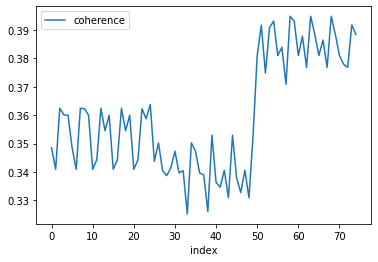

In [ ]:
tuningResults.plot(x="index", y="coherence");